In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

### Kích thước ảnh X-ray 
##### Định Dạng: JPEG
##### Kích thước: Vài trăm KB đến vài MB
##### Độ phân giải phổ biến: Độ phân giải phổ biến cho các hình ảnh X-quang ngực là từ 1024x1024 pixel đến 2048x2048 pixel.


In [ ]:
from PIL import Image
import tkinter as tk
from tkinter import filedialog

def show_image_size():
    # Mở hộp thoại để chọn file ảnh
    file_path = filedialog.askopenfilename(title="Chọn ảnh", filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.gif")])
    
    if file_path:
        # Mở ảnh và lấy kích thước
        with Image.open(file_path) as img:
            width, height = img.size
            size_label.config(text=f"Kích thước ảnh: {width} x {height} pixels")

# Tạo giao diện người dùng
root = tk.Tk()
root.title("Hiển thị kích thước ảnh")

size_label = tk.Label(root, text="Chưa chọn ảnh")
size_label.pack(pady=20)

select_button = tk.Button(root, text="Chọn ảnh", command=show_image_size)
select_button.pack(pady=20)

root.mainloop()

IMG_SIZE = 224: Thiết lập kích thước hình ảnh (image size) là 224x224 pixel. Đây là kích thước phổ biến được sử dụng trong các mô hình học sâu, đặc biệt là trong các mạng nơ-ron tích chập (CNN) như ResNet, VGG, và Inception. Kích thước này giúp chuẩn hóa tất cả các hình ảnh đầu vào trước khi đưa vào mô hình.

BATCH = 32: Thiết lập kích thước lô (batch size) là 32. Kích thước lô là số lượng mẫu (samples) mà mô hình sẽ xử lý trong một lần cập nhật trọng số (weight update) trong quá trình huấn luyện. Kích thước lô 32 thường được sử dụng vì nó cân bằng giữa tốc độ tính toán và hiệu quả sử dụng bộ nhớ.

SEED = 42: Thiết lập một giá trị hạt giống (seed) cho các phép toán ngẫu nhiên. Giá trị này được sử dụng để đảm bảo rằng các kết quả ngẫu nhiên có thể tái lập được. Việc sử dụng cùng một giá trị hạt giống sẽ giúp bạn có thể nhận được cùng một kết quả mỗi khi chạy lại mã, điều này rất quan trọng trong việc kiểm tra và so sánh các mô hình.

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
main_path = "F:\\KLTN\\KL\\data6\\chest_xray"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [5]:
import os
import glob

# Đường dẫn chính
main_path = r"F:\KLTN\KL\data6\chest_xray"

# Đường dẫn train và test
train_path = os.path.join(main_path, "train")
test_path = os.path.join(main_path, "test")

# Kiểm tra thư mục chính
if not os.path.exists(main_path):
    print(f"Thư mục chính không tồn tại: {main_path}")
else:
    print(f"Thư mục chính tồn tại: {main_path}")

# Kiểm tra các thư mục con
for sub_path in ["train/NORMAL", "train/PNEUMONIA", "test/NORMAL", "test/PNEUMONIA"]:
    full_path = os.path.join(main_path, sub_path.replace("/", os.sep))  # Đảm bảo sử dụng đúng dấu phân cách
    if not os.path.exists(full_path):
        print(f"Thư mục con không tồn tại: {full_path}")
    else:
        print(f"Thư mục con tồn tại: {full_path}")

# Tìm kiếm các tệp hình ảnh
train_normal = glob.glob(os.path.join(train_path, "NORMAL", "*.jpeg"))
train_pneumonia = glob.glob(os.path.join(train_path, "PNEUMONIA", "*.jpeg"))
test_normal = glob.glob(os.path.join(test_path, "NORMAL", "*.jpeg"))
test_pneumonia = glob.glob(os.path.join(test_path, "PNEUMONIA", "*.jpeg"))

# In số lượng tệp tìm thấy
print(f"Số lượng hình ảnh trong train/NORMAL: {len(train_normal)}")
print(f"Số lượng hình ảnh trong train/PNEUMONIA: {len(train_pneumonia)}")
print(f"Số lượng hình ảnh trong test/NORMAL: {len(test_normal)}")
print(f"Số lượng hình ảnh trong test/PNEUMONIA: {len(test_pneumonia)}")

# In danh sách tệp tìm thấy (nếu cần)
print("\nDanh sách tệp trong train/NORMAL:")
print(train_normal)

print("\nDanh sách tệp trong train/PNEUMONIA:")
print(train_pneumonia)

print("\nDanh sách tệp trong test/NORMAL:")
print(test_normal)

print("\nDanh sách tệp trong test/PNEUMONIA:")
print(test_pneumonia)


Thư mục chính tồn tại: F:\KLTN\KL\data6\chest_xray
Thư mục con tồn tại: F:\KLTN\KL\data6\chest_xray\train\NORMAL
Thư mục con tồn tại: F:\KLTN\KL\data6\chest_xray\train\PNEUMONIA
Thư mục con tồn tại: F:\KLTN\KL\data6\chest_xray\test\NORMAL
Thư mục con tồn tại: F:\KLTN\KL\data6\chest_xray\test\PNEUMONIA
Số lượng hình ảnh trong train/NORMAL: 268
Số lượng hình ảnh trong train/PNEUMONIA: 775
Số lượng hình ảnh trong test/NORMAL: 47
Số lượng hình ảnh trong test/PNEUMONIA: 76

Danh sách tệp trong train/NORMAL:
['F:\\KLTN\\KL\\data6\\chest_xray\\train\\NORMAL\\NORMAL2-IM-0919-0001.jpeg', 'F:\\KLTN\\KL\\data6\\chest_xray\\train\\NORMAL\\NORMAL2-IM-0922-0001.jpeg', 'F:\\KLTN\\KL\\data6\\chest_xray\\train\\NORMAL\\NORMAL2-IM-0923-0001.jpeg', 'F:\\KLTN\\KL\\data6\\chest_xray\\train\\NORMAL\\NORMAL2-IM-0924-0001.jpeg', 'F:\\KLTN\\KL\\data6\\chest_xray\\train\\NORMAL\\NORMAL2-IM-0925-0001.jpeg', 'F:\\KLTN\\KL\\data6\\chest_xray\\train\\NORMAL\\NORMAL2-IM-0926-0001.jpeg', 'F:\\KLTN\\KL\\data6\\chest_x

In [6]:
df_train

class  \
0        Normal   
1        Normal   
2        Normal   
3        Normal   
4        Normal   
...         ...   
1038  Pneumonia   
1039  Pneumonia   
1040  Pneumonia   
1041  Pneumonia   
1042  Pneumonia   

                                                                          image  
0            F:\KLTN\KL\data6\chest_xray\train/NORMAL\NORMAL2-IM-0919-0001.jpeg  
1            F:\KLTN\KL\data6\chest_xray\train/NORMAL\NORMAL2-IM-0922-0001.jpeg  
2            F:\KLTN\KL\data6\chest_xray\train/NORMAL\NORMAL2-IM-0923-0001.jpeg  
3            F:\KLTN\KL\data6\chest_xray\train/NORMAL\NORMAL2-IM-0924-0001.jpeg  
4            F:\KLTN\KL\data6\chest_xray\train/NORMAL\NORMAL2-IM-0925-0001.jpeg  
...                                                                         ...  
1038  F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1814_bacteria_4669.jpeg  
1039  F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1816_bacteria_4673.jpeg  
1040  F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1816_bacteria_4674.jpeg  
1041  F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1817_bacteria_4675.jpeg  
1042  F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1818_bacteria_4676.jpeg  

[1043 rows x 2 columns]

In [7]:
df_test

class  \
0       Normal   
1       Normal   
2       Normal   
3       Normal   
4       Normal   
..         ...   
118  Pneumonia   
119  Pneumonia   
120  Pneumonia   
121  Pneumonia   
122  Pneumonia   

                                                                      image  
0                 F:\KLTN\KL\data6\chest_xray\test/NORMAL\IM-0083-0001.jpeg  
1                 F:\KLTN\KL\data6\chest_xray\test/NORMAL\IM-0084-0001.jpeg  
2                 F:\KLTN\KL\data6\chest_xray\test/NORMAL\IM-0085-0001.jpeg  
3                 F:\KLTN\KL\data6\chest_xray\test/NORMAL\IM-0086-0001.jpeg  
4                 F:\KLTN\KL\data6\chest_xray\test/NORMAL\IM-0087-0001.jpeg  
..                                                                      ...  
118  F:\KLTN\KL\data6\chest_xray\test/PNEUMONIA\person173_bacteria_831.jpeg  
119  F:\KLTN\KL\data6\chest_xray\test/PNEUMONIA\person174_bacteria_832.jpeg  
120  F:\KLTN\KL\data6\chest_xray\test/PNEUMONIA\person175_bacteria_833.jpeg  
121  F:\KLTN\KL\data6\chest_xray\test/PNEUMONIA\person175_bacteria_834.jpeg  
122  F:\KLTN\KL\data6\chest_xray\test/PNEUMONIA\person175_bacteria_835.jpeg  

[123 rows x 2 columns]

### Trực quan hóa Dữ liệu

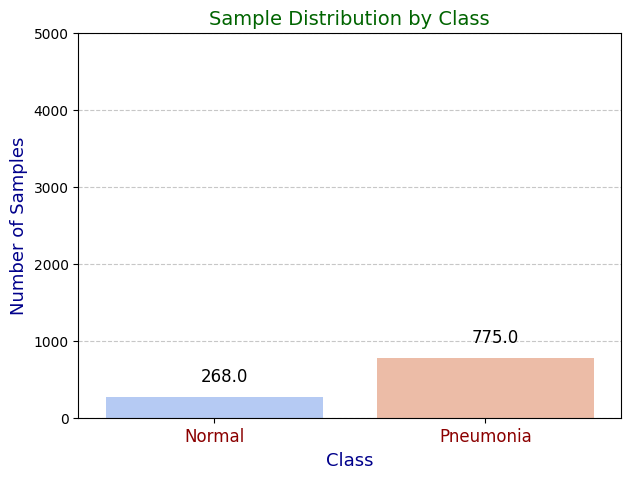

In [8]:
plt.figure(figsize=(7, 5))  # Tăng kích thước đồ thị
ax = sns.countplot(x='class', data=df_train, palette="coolwarm")  # Thay đổi màu sắc
plt.xlabel("Class", fontsize=13, color="darkblue")  # Đổi màu và tăng kích thước chữ
plt.ylabel("Number of Samples", fontsize=13, color="darkblue")  # Đổi màu và tăng kích thước chữ
plt.ylim(0, 5000)
plt.xticks([0, 1], ['Normal', 'Pneumonia'], fontsize=12, color="darkred")  # Đổi màu và phông chữ
plt.title("Sample Distribution by Class", fontsize=14, color="darkgreen")  # Thêm tiêu đề

# Hiển thị giá trị trên cột
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()}",  # Giá trị cao nhất
        (p.get_x() + 0.35, p.get_height() + 200),  # Vị trí hiển thị
        fontsize=12, color="black", fontweight="bold"
    )

plt.grid(axis="y", linestyle="--", alpha=0.7)  # Thêm lưới ngang
plt.show()

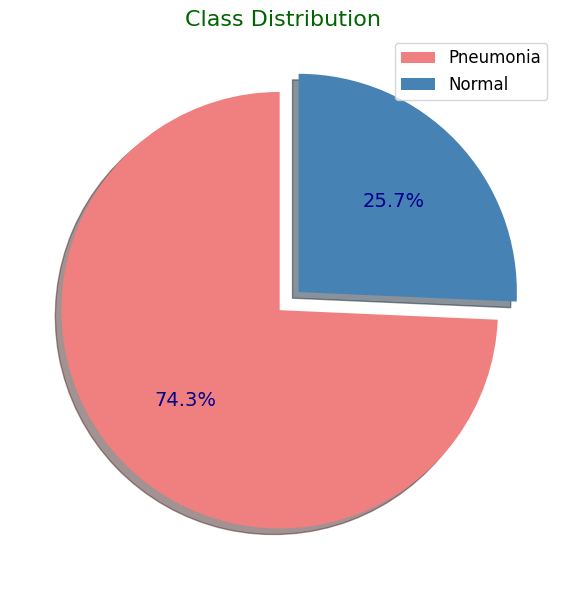

In [9]:
plt.figure(figsize=(8, 6))  # Tăng kích thước đồ thị

# Vẽ biểu đồ hình tròn với các tùy chọn tùy chỉnh
df_train['class'].value_counts().plot(
    kind='pie',
    labels=['', ''],  # Không hiển thị nhãn trực tiếp
    autopct='%1.1f%%',  # Hiển thị phần trăm
    colors=['lightcoral', 'steelblue'],  # Thay đổi màu sắc
    explode=[0.02, 0.1],  # Tách biệt một phần biểu đồ
    textprops={"fontsize": 14, "color": "darkblue"},  # Định dạng chữ
    shadow=True,  # Thêm hiệu ứng bóng
    startangle=90  # Bắt đầu từ góc 90 độ
)

# Thêm chú thích
plt.legend(labels=['Pneumonia', 'Normal'], fontsize=12, loc="upper right")  # Chú thích rõ ràng
plt.title("Class Distribution", fontsize=16, color="darkgreen", weight='bold')  # Thêm tiêu đề

plt.ylabel("")  # Bỏ nhãn trục y
plt.tight_layout()  # Điều chỉnh bố cục
plt.show()


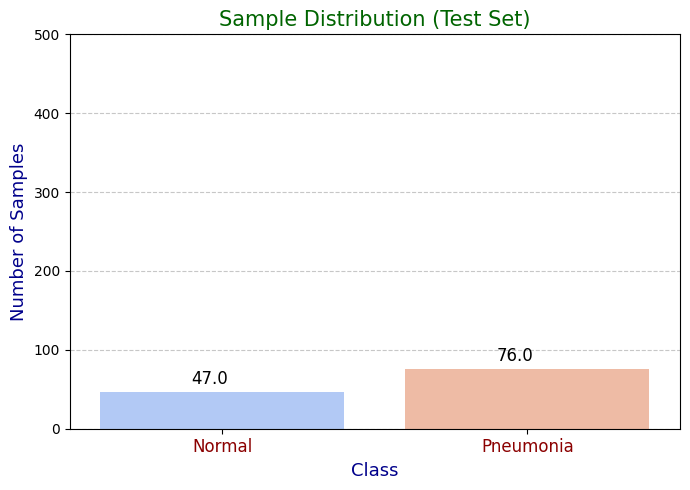

In [10]:
# Kích thước biểu đồ
plt.figure(figsize=(7, 5))

# Biểu đồ đếm với màu sắc mới
ax = sns.countplot(
    x='class', 
    data=df_test, 
    palette="coolwarm",  # Thay đổi palette màu
    saturation=0.8  # Tăng độ rõ ràng
)

# Thay đổi nhãn và trục
plt.xlabel("Class", fontsize=13, color="darkblue")  # Đổi màu và kích thước nhãn x
plt.ylabel("Number of Samples", fontsize=13, color="darkblue")  # Đổi màu và kích thước nhãn y
plt.ylim(0, 500)  # Đặt giới hạn trục y
plt.xticks([0, 1], ['Normal', 'Pneumonia'], fontsize=12, color="darkred")  # Thay đổi nhãn x
plt.title("Sample Distribution (Test Set)", fontsize=15, color="darkgreen")  # Thêm tiêu đề

# Hiển thị giá trị trên từng cột
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()}",  # Giá trị
        (p.get_x() + 0.3, p.get_height() + 10),  # Vị trí
        fontsize=12, color="black", fontweight="bold"
    )

# Thêm lưới ngang để dễ theo dõi
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # Điều chỉnh bố cục gọn gàng
plt.show()

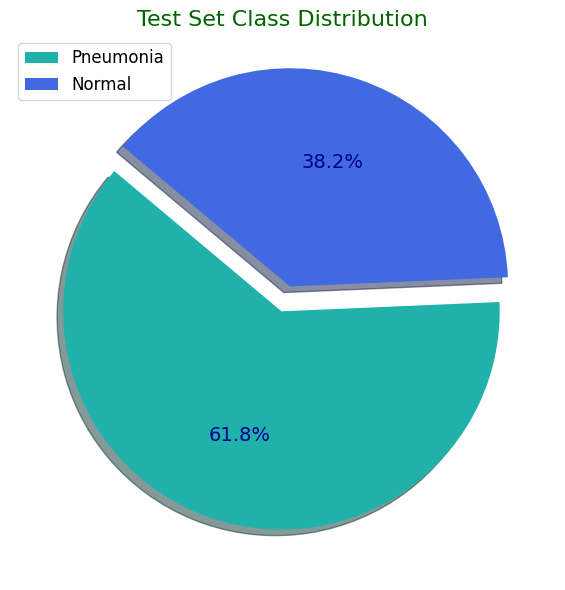

In [11]:
plt.figure(figsize=(8, 6))  # Tăng kích thước đồ thị

# Vẽ biểu đồ hình tròn
df_test['class'].value_counts().plot(
    kind='pie',
    labels=['', ''],  # Không hiển thị nhãn trực tiếp
    autopct='%1.1f%%',  # Hiển thị phần trăm
    colors=['lightseagreen', 'royalblue'],  # Thay đổi màu sắc
    explode=[0.02, 0.1],  # Tách biệt một phần biểu đồ
    textprops={"fontsize": 14, "color": "darkblue"},  # Định dạng chữ
    shadow=True,  # Thêm hiệu ứng bóng
    startangle=140  # Bắt đầu từ góc 140 độ để cân đối
)

# Thêm chú thích
plt.legend(labels=['Pneumonia', 'Normal'], fontsize=12, loc="best")  # Chú thích rõ ràng
plt.title("Test Set Class Distribution", fontsize=16, color="darkgreen", weight='bold')  # Thêm tiêu đề

plt.ylabel("")  # Bỏ nhãn trục y
plt.tight_layout()  # Điều chỉnh bố cục gọn gàng
plt.show()

Train Set - Normal


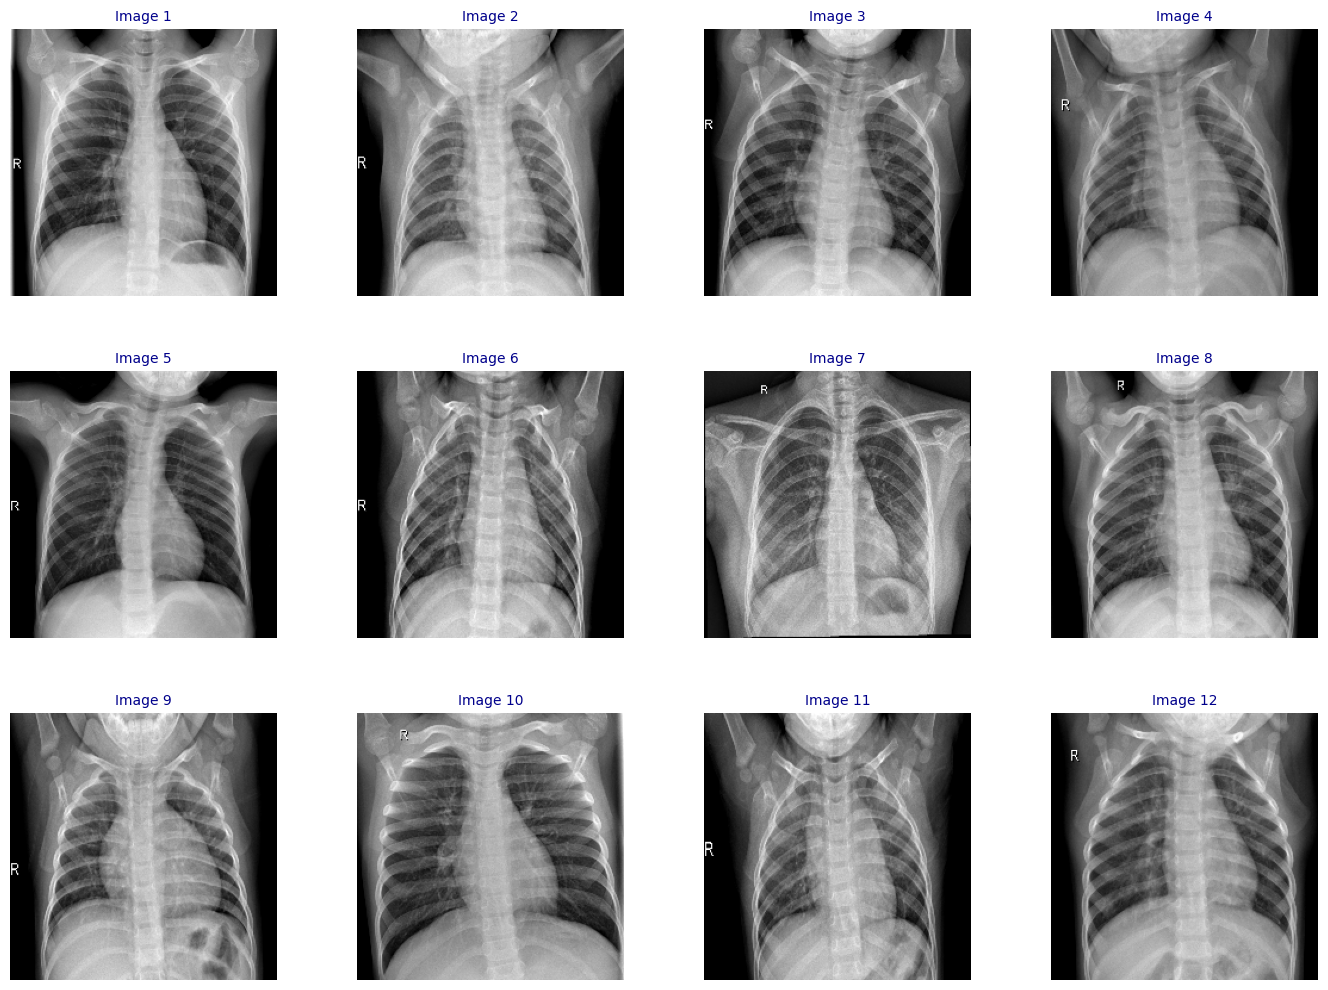

In [12]:
# Hiển thị tiêu đề tập dữ liệu
print('Train Set - Normal')

# Cấu hình kích thước biểu đồ
plt.figure(figsize=(14, 10))  # Tăng kích thước tổng thể

# Hiển thị 12 ảnh mẫu
for i in range(12):
    plt.subplot(3, 4, i + 1)  # 3 hàng x 4 cột
    img = cv2.imread(train_normal[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang định dạng RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Điều chỉnh kích thước ảnh
    plt.imshow(img)
    plt.axis("off")  # Tắt trục

    # Thêm tiêu đề cho từng ảnh
    plt.title(f"Image {i+1}", fontsize=10, color='darkblue')

# Tăng khoảng cách giữa các ảnh
plt.tight_layout(w_pad=2, h_pad=4)

# Hiển thị đồ thị
plt.show()

Train Set - Pneumonia


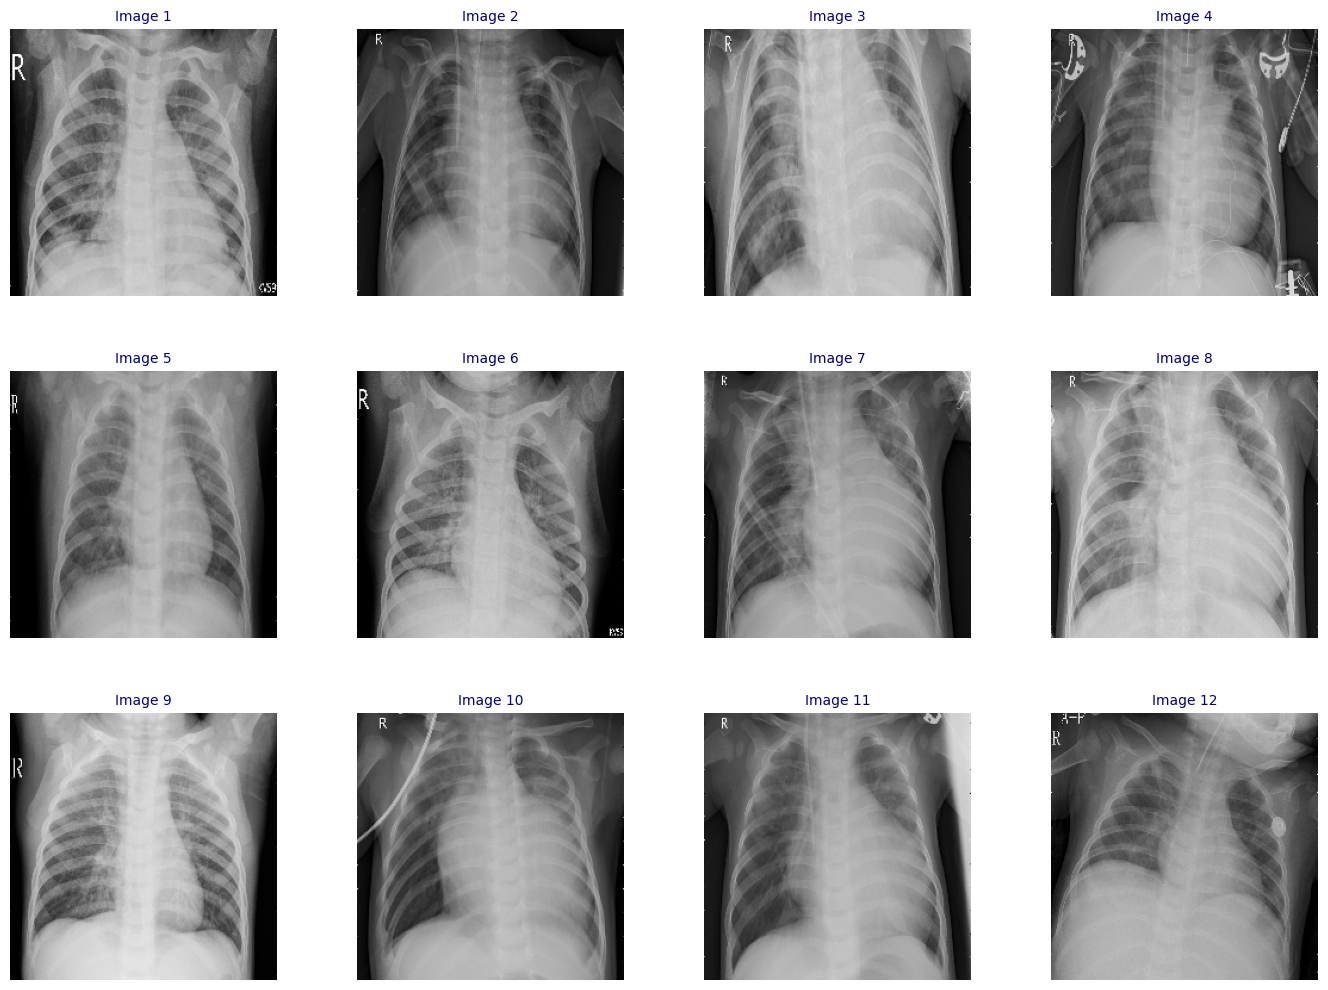

In [13]:
print('Train Set - Pneumonia')
# Cấu hình kích thước biểu đồ
plt.figure(figsize=(14, 10))  # Tăng kích thước tổng thể

# Hiển thị 12 ảnh mẫu
for i in range(12):
    plt.subplot(3, 4, i + 1)  # 3 hàng x 4 cột
    img = cv2.imread(train_pneumonia[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang định dạng RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Điều chỉnh kích thước ảnh
    plt.imshow(img)
    plt.axis("off")  # Tắt trục

    # Thêm tiêu đề cho từng ảnh
    plt.title(f"Image {i+1}", fontsize=10, color='darkblue')

# Tăng khoảng cách giữa các ảnh
plt.tight_layout(w_pad=2, h_pad=4)

# Hiển thị đồ thị
plt.show()

Test set -normal


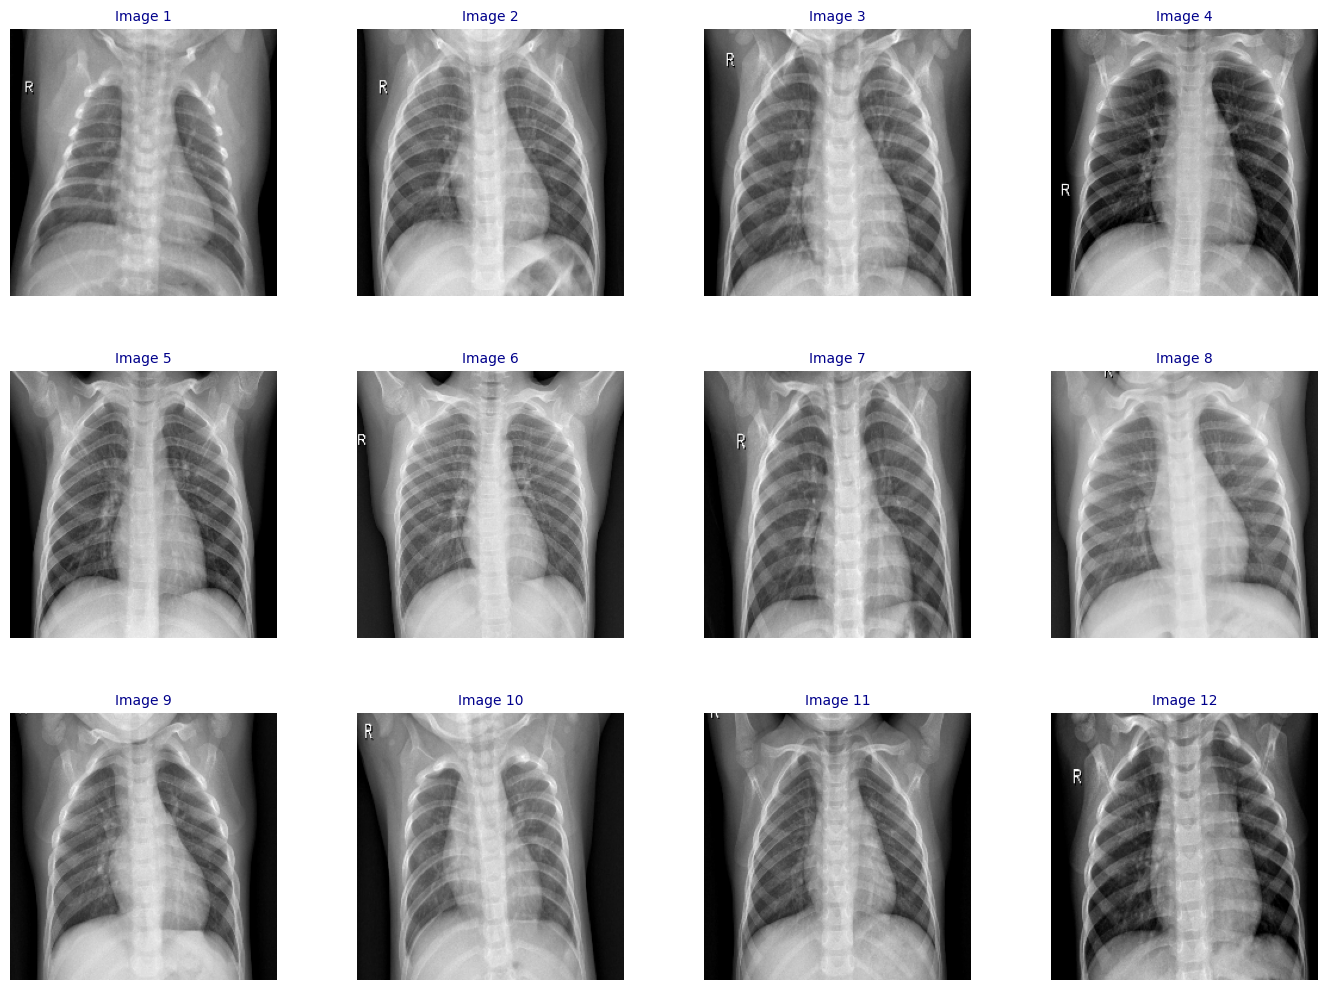

In [14]:
print('Test set -normal')
# Cấu hình kích thước biểu đồ
plt.figure(figsize=(14, 10))  # Tăng kích thước tổng thể

# Hiển thị 12 ảnh mẫu
for i in range(12):
    plt.subplot(3, 4, i + 1)  # 3 hàng x 4 cột
    img = cv2.imread(test_normal[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang định dạng RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Điều chỉnh kích thước ảnh
    plt.imshow(img)
    plt.axis("off")  # Tắt trục

    # Thêm tiêu đề cho từng ảnh
    plt.title(f"Image {i+1}", fontsize=10, color='darkblue')

# Tăng khoảng cách giữa các ảnh
plt.tight_layout(w_pad=2, h_pad=4)

# Hiển thị đồ thị
plt.show()

Test Set - Pneumonia


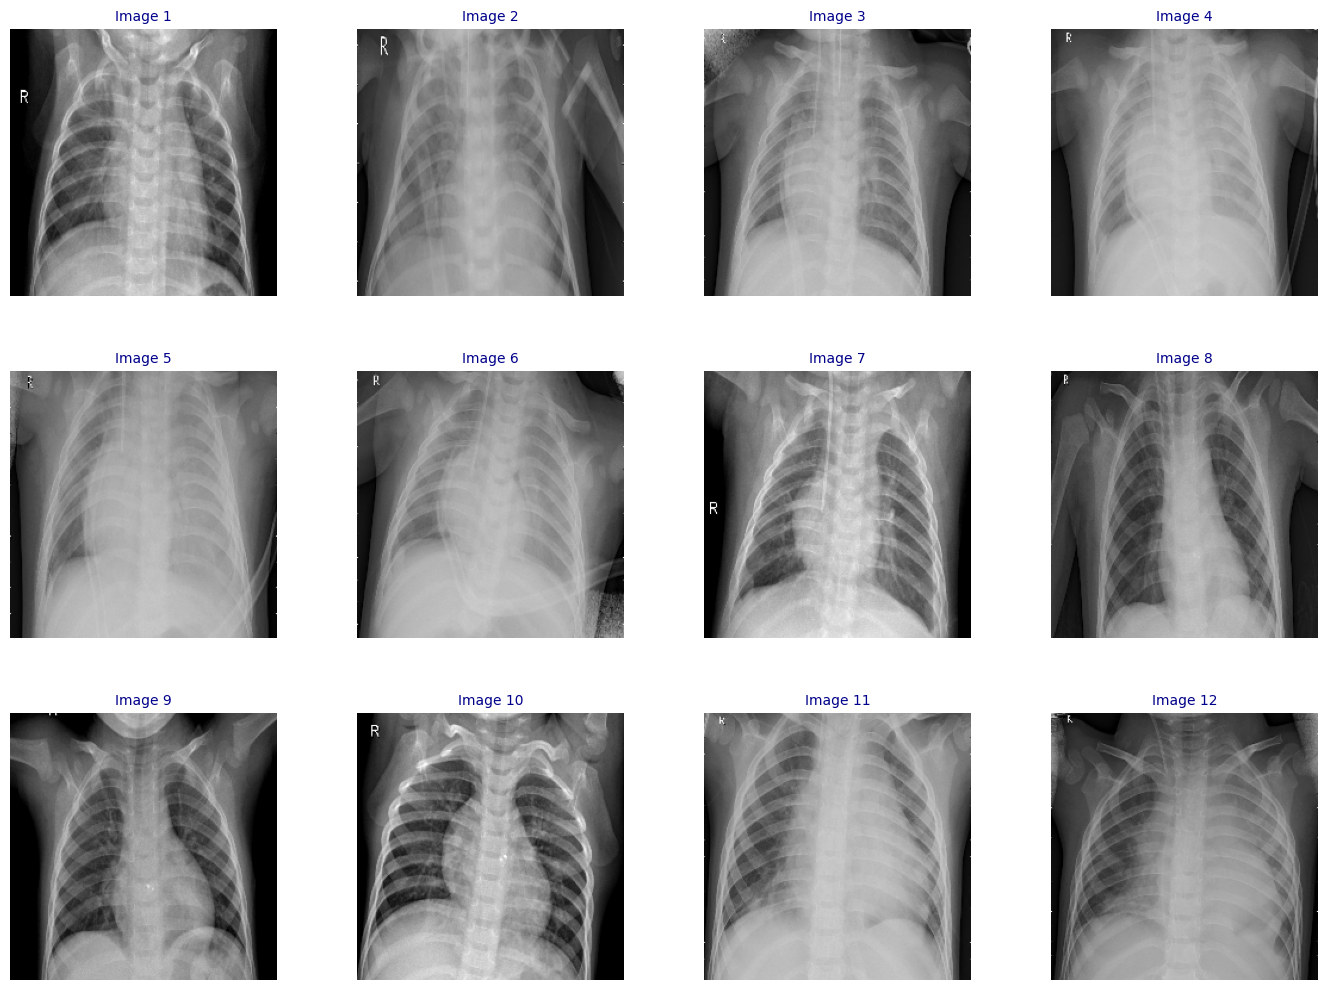

In [15]:
print('Test Set - Pneumonia')
# Cấu hình kích thước biểu đồ
plt.figure(figsize=(14, 10))  # Tăng kích thước tổng thể

# Hiển thị 12 ảnh mẫu
for i in range(12):
    plt.subplot(3, 4, i + 1)  # 3 hàng x 4 cột
    img = cv2.imread(test_pneumonia[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang định dạng RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Điều chỉnh kích thước ảnh
    plt.imshow(img)
    plt.axis("off")  # Tắt trục

    # Thêm tiêu đề cho từng ảnh
    plt.title(f"Image {i+1}", fontsize=10, color='darkblue')

# Tăng khoảng cách giữa các ảnh
plt.tight_layout(w_pad=2, h_pad=4)

# Hiển thị đồ thị
plt.show()

#### Chuẩn bị dữ liệu
Đầu tiên, chúng ta cần tạo một tập xác thực. Để làm điều đó, chúng ta áp dụng một phân chia phân tầng đơn giản trên tập dữ liệu đào tạo ban đầu, sử dụng 80% cho mục đích đào tạo thực tế và 20% cho mục đích xác thực.

In [81]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [82]:
train_df

class  \
477  Pneumonia   
442  Pneumonia   
327  Pneumonia   
843  Pneumonia   
147     Normal   
..         ...   
356  Pneumonia   
286  Pneumonia   
933  Pneumonia   
152     Normal   
486  Pneumonia   

                                                                         image  
477  F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1154_bacteria_3099.jpeg  
442  F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1135_bacteria_3077.jpeg  
327     F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1065_virus_1768.jpeg  
843     F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1331_virus_2299.jpeg  
147         F:\KLTN\KL\data6\chest_xray\train/NORMAL\NORMAL2-IM-1112-0001.jpeg  
..                                                                         ...  
356     F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1080_virus_1791.jpeg  
286     F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1038_virus_1733.jpeg  
933     F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1369_virus_2356.jpeg  
152         F:\KLTN\KL\data6\chest_xray\train/NORMAL\NORMAL2-IM-1116-0001.jpeg  
486  F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1158_bacteria_3103.jpeg  

[834 rows x 2 columns]

In [83]:
val_df

class  \
727  Pneumonia   
497  Pneumonia   
569  Pneumonia   
134     Normal   
523  Pneumonia   
..         ...   
402  Pneumonia   
689  Pneumonia   
550  Pneumonia   
430  Pneumonia   
72      Normal   

                                                                         image  
727     F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1287_virus_2210.jpeg  
497     F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1160_virus_1947.jpeg  
569  F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1192_bacteria_3141.jpeg  
134         F:\KLTN\KL\data6\chest_xray\train/NORMAL\NORMAL2-IM-1098-0001.jpeg  
523     F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1173_virus_1978.jpeg  
..                                                                         ...  
402     F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1107_virus_1831.jpeg  
689     F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1266_virus_2158.jpeg  
550     F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1180_virus_2015.jpeg  
430  F:\KLTN\KL\data6\chest_xray\train/PNEUMONIA\person1127_bacteria_3068.jpeg  
72          F:\KLTN\KL\data6\chest_xray\train/NORMAL\NORMAL2-IM-1008-0001.jpeg  

[209 rows x 2 columns]

Bây giờ, chúng ta sẽ tải hình ảnh từ các thư mục và chuẩn bị chúng để đưa vào mô hình.

Bắt đầu bằng cách định nghĩa các trình tạo dữ liệu. Với Keras Image Data Generator, tôi có thể thay đổi tỷ lệ các giá trị pixel và áp dụng các kỹ thuật biến đổi ngẫu nhiên để tăng dữ liệu ngay lập tức. Chúng tôi định nghĩa hai trình tạo khác nhau. val_datagen được sử dụng để chỉ thay đổi tỷ lệ các tập xác thực và kiểm tra. train_datagen bao gồm một số phép biến đổi để tăng cường tập huấn luyện.

Áp dụng các trình tạo đó trên mỗi tập dữ liệu bằng phương pháp flow_from_dataframe. Ngoài các phép biến đổi được xác định trong mỗi trình tạo, các hình ảnh cũng được thay đổi kích thước dựa trên tập target_size.

In [84]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 834 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 123 validated image filenames belonging to 2 classes.


#### Tinh chỉnh model


In [85]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [86]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [87]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [88]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
26/26 [==============================] - 34s 1s/step - loss: 0.7105 - binary_accuracy: 0.7218 - val_loss: 0.6177 - val_binary_accuracy: 0.7416 - lr: 3.0000e-05
Epoch 2/50
26/26 [==============================] - 33s 1s/step - loss: 0.4356 - binary_accuracy: 0.8094 - val_loss: 0.5700 - val_binary_accuracy: 0.7416 - lr: 3.0000e-05
Epoch 3/50
26/26 [==============================] - 32s 1s/step - loss: 0.4328 - binary_accuracy: 0.8106 - val_loss: 0.6263 - val_binary_accuracy: 0.7416 - lr: 3.0000e-05
Epoch 4/50
27/26 [===============================] - ETA: -1s - loss: 0.3572 - binary_accuracy: 0.8453
Epoch 4: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
26/26 [==============================] - 32s 1s/step - loss: 0.3572 - binary_accuracy: 0.8453 - val_loss: 0.7430 - val_binary_accuracy: 0.7416 - lr: 3.0000e-05
Epoch 5/50
26/26 [==============================] - 32s 1s/step - loss: 0.3421 - binary_accuracy: 0.8417 - val_loss: 0.8163 - val_binary_accuracy: 

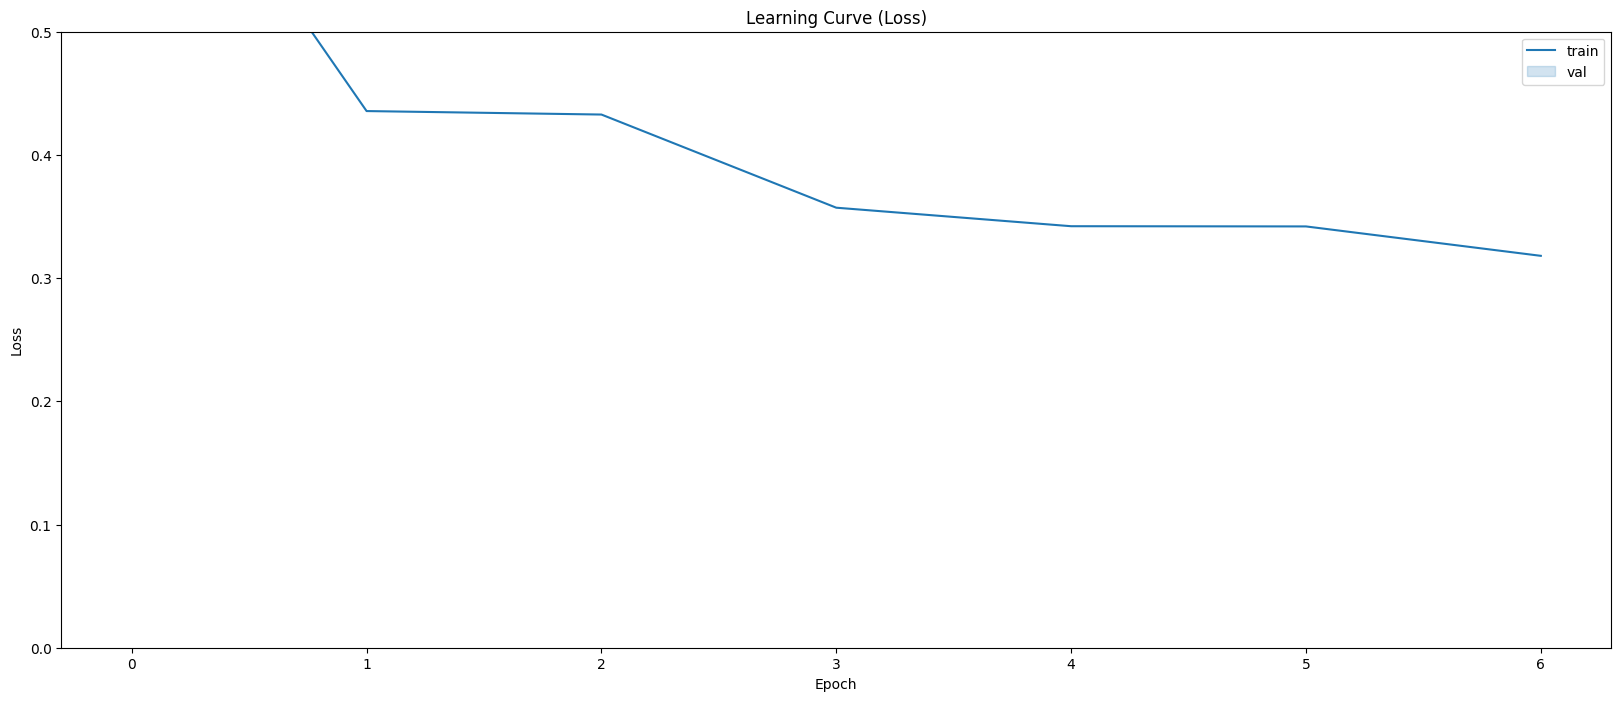

In [89]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

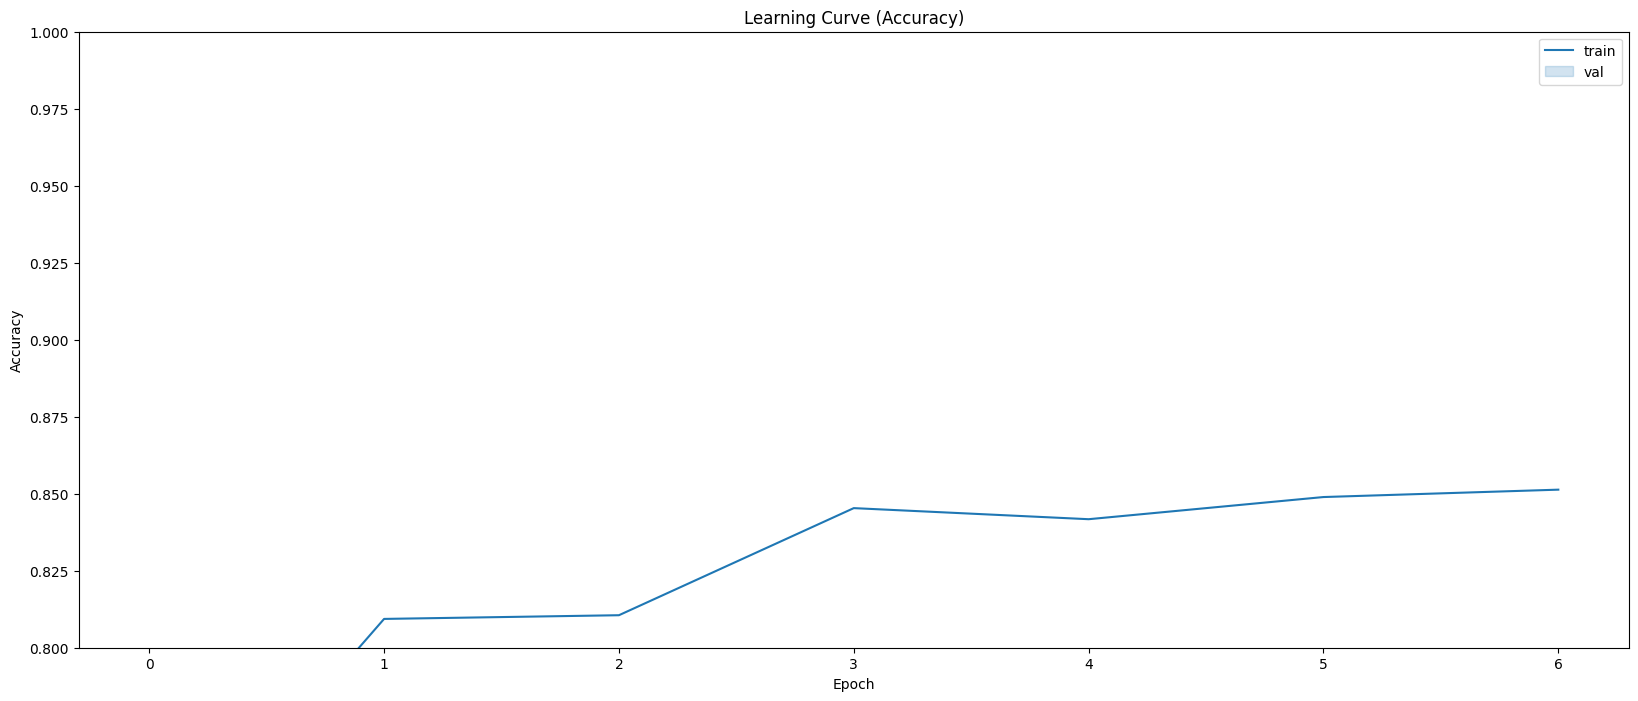

In [90]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [91]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.5700247883796692
Val accuracy: 0.7416267991065979


In [92]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.714431881904602
Test accuracy: 0.6178861856460571


In [93]:
model.save('tram4.h5')  # Lưu mô hình vào file my_model.h5

In [7]:
from keras.models import load_model

model = load_model('tram4.h5')  # Tải mô hình từ file my_model.h5

In [10]:
from keras.preprocessing import image
import numpy as np

# Đường dẫn đến hình ảnh bạn muốn kiểm tra
#img_path = 'F:\\KLTN\\KL\\person100_bacteria_478.jpeg'
# img_path ='F:\\KLTN\\KL\\COVID19(463).jpg'
img_path = 'F:\\KLTN\\KL\\phoi_binh_thuong.jpg'
# img_path = 'F:\\KLTN\\KL\\viem_phoi.jpg'
# Tải và chuẩn bị hình ảnh
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))  # Thay IMG_SIZE bằng kích thước đầu vào của mô hình
img_array = image.img_to_array(img)  # Chuyển đổi hình ảnh thành mảng numpy
img_array = np.expand_dims(img_array, axis=0)  # Thêm một chiều để tạo thành batch

# Tiền xử lý (nếu cần thiết)
img_array /= 255.0  # Nếu bạn đã chuẩn hóa dữ liệu trong quá trình huấn luyện

In [11]:
# Assuming predictions is the output from model.predict(img_array)
predictions = model.predict(img_array)
predicted_probability = predictions[0][0]  # Get the probability for the positive class
predicted_percentage = predicted_probability * 100  # Convert to percentage

print('Predicted probability:', predicted_probability)
print('Predicted percentage: {:.2f}%'.format(predicted_percentage))

1/1 [==============================] - 0s 22ms/step
Predicted probability: 0.760754
Predicted percentage: 76.08%


##### Học chuyển giao

In [97]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [98]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [99]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
26/26 [==============================] - 112s 4s/step - loss: 0.6540 - binary_accuracy: 0.6391 - val_loss: 0.4464 - val_binary_accuracy: 0.7799 - lr: 5.0000e-05
Epoch 2/50
26/26 [==============================] - 103s 4s/step - loss: 0.4122 - binary_accuracy: 0.8189 - val_loss: 0.3243 - val_binary_accuracy: 0.9139 - lr: 5.0000e-05
Epoch 3/50
26/26 [==============================] - 104s 4s/step - loss: 0.3045 - binary_accuracy: 0.9029 - val_loss: 0.2549 - val_binary_accuracy: 0.9187 - lr: 5.0000e-05
Epoch 4/50
26/26 [==============================] - 103s 4s/step - loss: 0.2546 - binary_accuracy: 0.9113 - val_loss: 0.2219 - val_binary_accuracy: 0.9330 - lr: 5.0000e-05
Epoch 5/50
26/26 [==============================] - 104s 4s/step - loss: 0.2260 - binary_accuracy: 0.9197 - val_loss: 0.2068 - val_binary_accuracy: 0.9378 - lr: 5.0000e-05
Epoch 6/50
26/26 [==============================] - 104s 4s/step - loss: 0.2018 - binary_accuracy: 0.9329 - val_loss: 0.1885 - val_binary_ac

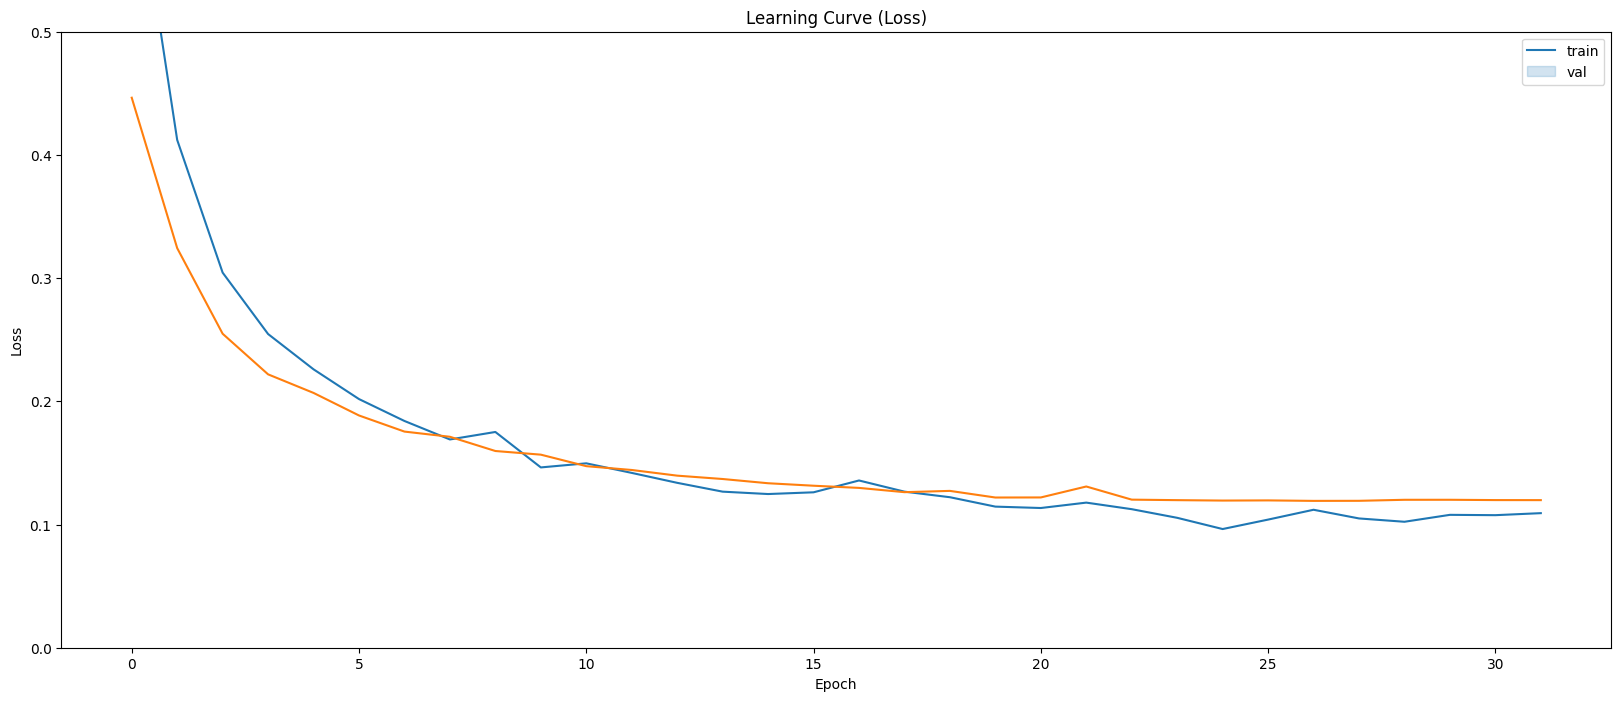

In [100]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

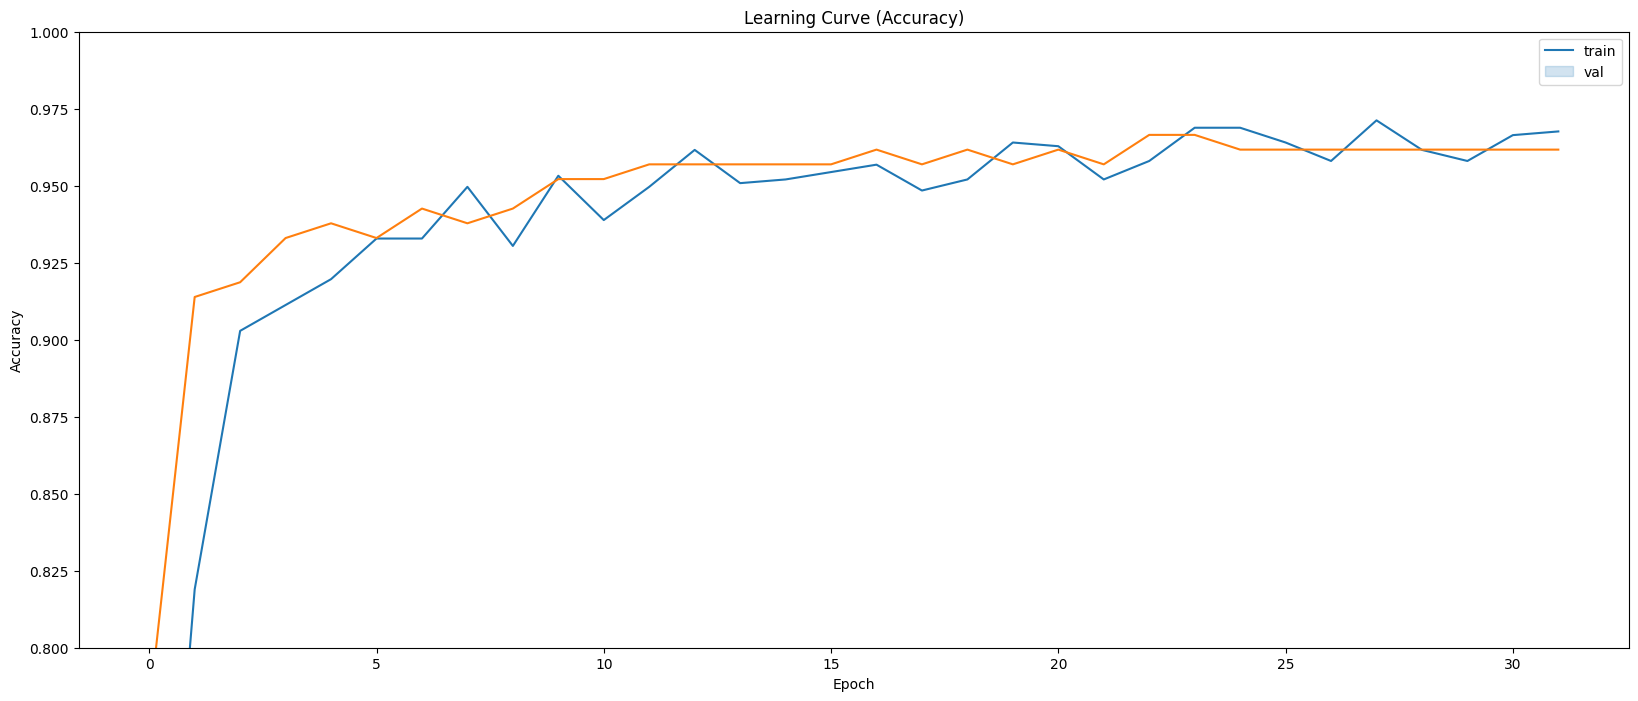

In [101]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [102]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.11918587982654572
Val accuracy: 0.9617224931716919


In [103]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.46604976058006287
Test accuracy: 0.8292682766914368


In [104]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [105]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [106]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-6), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [107]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
26/26 [==============================] - 120s 4s/step - loss: 0.2134 - binary_accuracy: 0.9221 - val_loss: 0.1160 - val_binary_accuracy: 0.9522 - lr: 2.0000e-06
Epoch 2/50
26/26 [==============================] - 110s 4s/step - loss: 0.2198 - binary_accuracy: 0.9233 - val_loss: 0.1273 - val_binary_accuracy: 0.9522 - lr: 2.0000e-06
Epoch 3/50
27/26 [===============================] - ETA: -3s - loss: 0.1953 - binary_accuracy: 0.9472
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
26/26 [==============================] - 110s 4s/step - loss: 0.1953 - binary_accuracy: 0.9472 - val_loss: 0.1391 - val_binary_accuracy: 0.9569 - lr: 2.0000e-06
Epoch 4/50
26/26 [==============================] - 113s 4s/step - loss: 0.1888 - binary_accuracy: 0.9412 - val_loss: 0.1510 - val_binary_accuracy: 0.9569 - lr: 4.0000e-07
Epoch 5/50
27/26 [===============================] - ETA: -3s - loss: 0.1902 - binary_accuracy: 0.9448
Epoch 5: ReduceLROnPlateau reducing learn

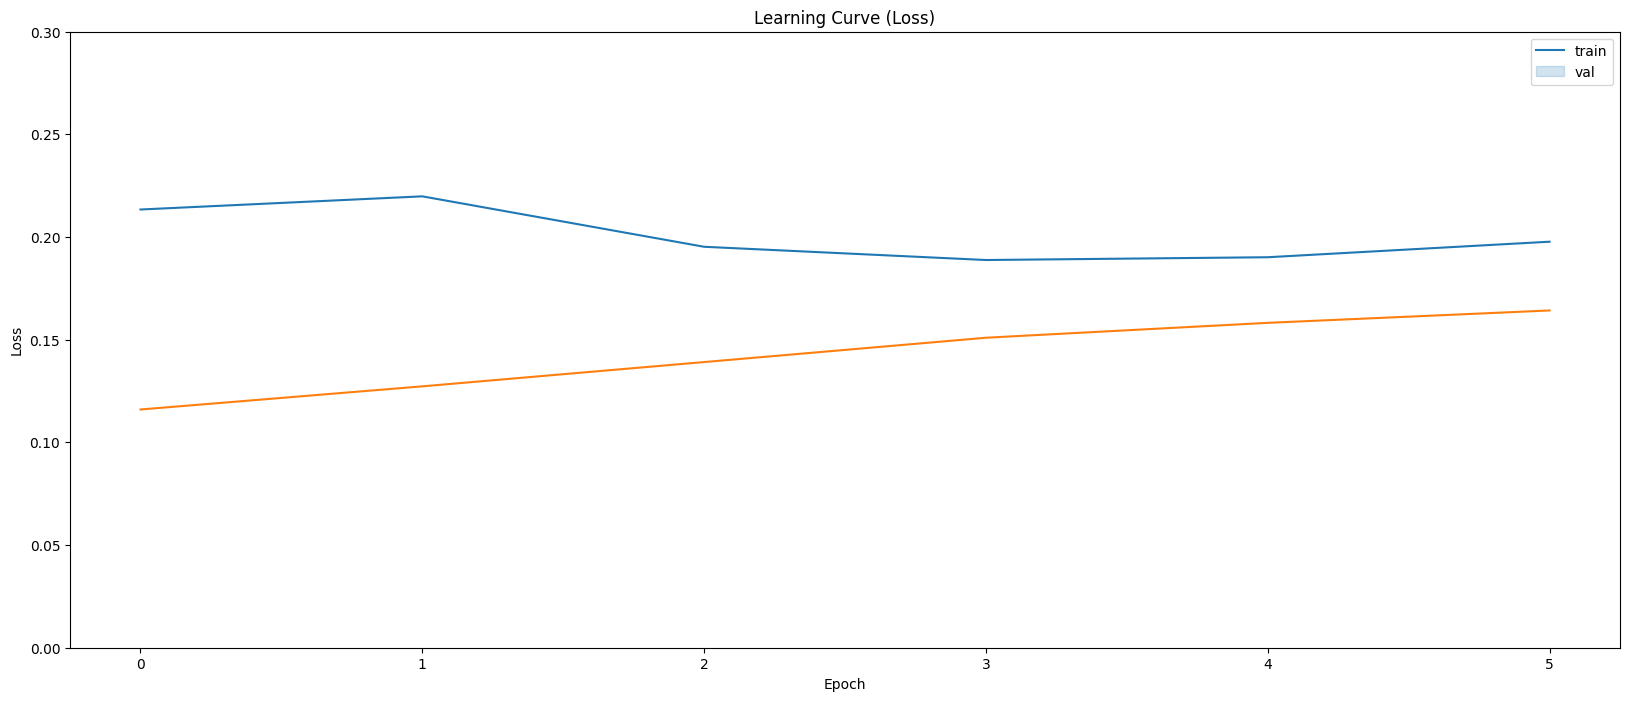

In [108]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()

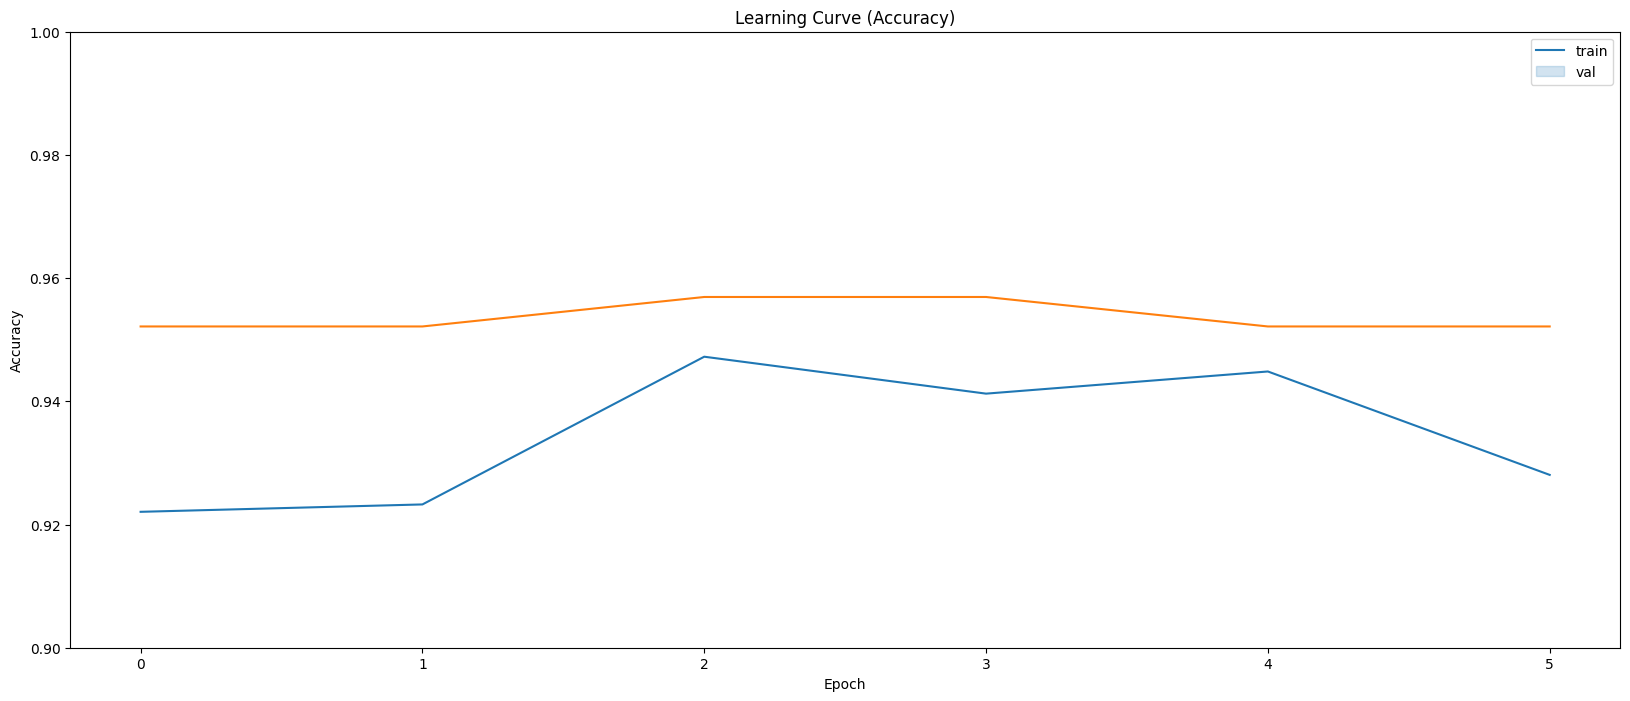

In [109]:

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [110]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.11602190136909485
Val accuracy: 0.9521530866622925


In [111]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.43636035919189453
Test accuracy: 0.8048780560493469


In [112]:
# Lưu mô hình đã huấn luyện
model_pretrained.save('tram4_resnet_model.h5')
print("Mô hình đã được lưu thành công!")

Mô hình đã được lưu thành công!


In [1]:
# Tải mô hình đã lưu
from tensorflow.keras.models import load_model

loaded_model = load_model('tram4_resnet_model.h5')
print("Mô hình đã được tải thành công!")


Mô hình đã được tải thành công!


In [ ]:
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np

# Tải một hình ảnh (đường dẫn 'img_path') và thay đổi kích thước
IMG_SIZE = 224  # Kích thước hình ảnh đã định nghĩa trước
# img_path = 'F:\\KLTN\\KL\\COVID19(463).jpg'  # Đường dẫn đến hình ảnh cần kiểm tra
# img_path = 'F:\\KLTN\\KL\\person100_bacteria_478.jpeg'
# img_path = 'F:\\KLTN\\KL\\phoi_binh_thuong.jpg'
img_path = 'F:\\KLTN\\KL\\viem_phoi.jpg'
image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))  # Sử dụng img_path thay vì image_path
image_array = img_to_array(image)  # Chuyển thành mảng numpy
image_array = np.expand_dims(image_array, axis=0)  # Thêm batch dimension
image_array = image_array / 255.0  # Chuẩn hóa giá trị pixel về [0, 1]


In [5]:
# Dự đoán nhãn của hình ảnh
prediction = loaded_model.predict(image_array)

# Chuyển đổi xác suất thành nhãn nhị phân
predicted_label = 1 if prediction > 0.5 else 0

# Xác định nhãn dự đoán
if predicted_label == 1:
    diagnosis = "Có bệnh viêm phổi"
else:
    diagnosis = "Không có bệnh viêm phổi"

print(f"Xác suất dự đoán: {prediction[0][0]:.4f}")  # In xác suất với 4 chữ số thập phân
print(f"Nhãn dự đoán: {diagnosis}")


1/1 [==============================] - 0s 141ms/step
Xác suất dự đoán: 0.9938
Nhãn dự đoán: Có bệnh viêm phổi


In [116]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [117]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [118]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.8048780487804879


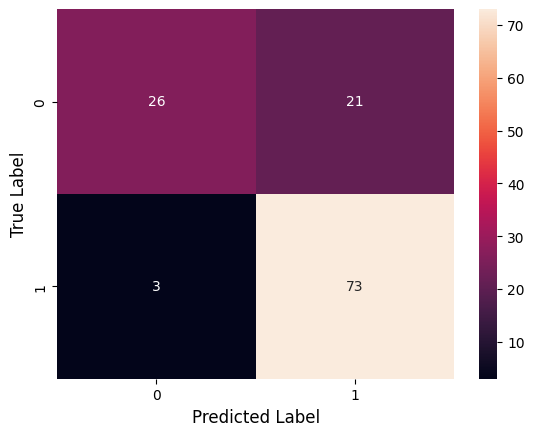

In [119]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [120]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.90      0.55      0.68        47
           1       0.78      0.96      0.86        76

    accuracy                           0.80       123
   macro avg       0.84      0.76      0.77       123
weighted avg       0.82      0.80      0.79       123



In [121]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.90      0.55      0.68        47
           1       0.78      0.96      0.86        76

    accuracy                           0.80       123
   macro avg       0.84      0.76      0.77       123
weighted avg       0.82      0.80      0.79       123



ROC_AUC:  0.9193729003359462


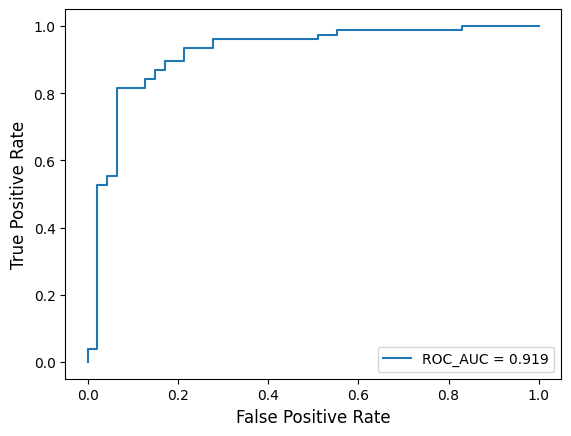

In [122]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()